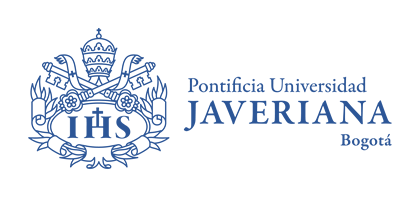

# Tecnologías emergentes - Proyecto

## Integrantes
- Andrés García Montoya
- Nicolás David Rincón Ballesteros
- Alejandro Enrique Suárez Acosta

In [1]:
# pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import cv2


In [2]:
import tensorflow as tf

# Check for GPU availability
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available.")
else:
    print("GPU is NOT available.")

GPU is NOT available.


In [3]:
#import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Get the current working directory
cwd = os.getcwd()

# Directory containing your data folders
data_dir = os.path.join(cwd, 'data')

# Inicializa listas para almacenar las imágenes y sus etiquetas
images = []
labels = []

classes = ['cloudy', 'water', 'green_area', 'desert']


In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Iterate through the classes and load the images
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        # Read the image and resize if needed
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224 pixels
        images.append(img)
        labels.append(class_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Análisis exploratorio de datos

### Visualización básica de las imágenes

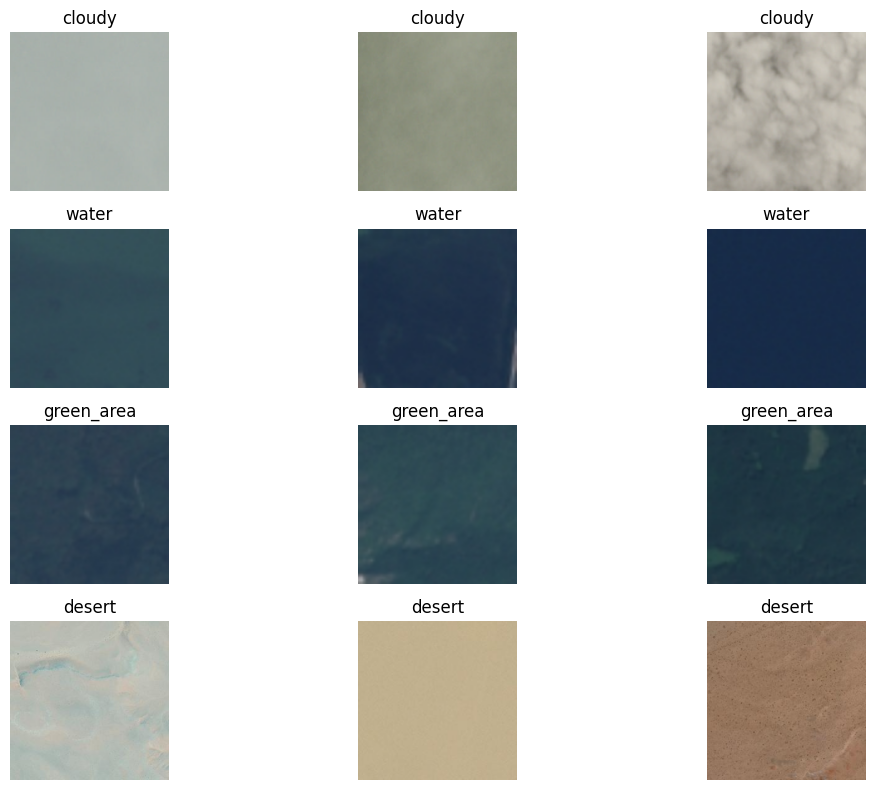

In [8]:
# Get indices of images per category
indices_per_category = {}
for class_name in classes:
    indices_per_category[class_name] = np.where(labels == class_name)[0]

# Display some images from each category
plt.figure(figsize=(12, 8))
num_images_per_category = 3
for i, class_name in enumerate(classes):
    indices = indices_per_category[class_name][:num_images_per_category]
    for j, index in enumerate(indices):
        plt.subplot(len(classes), num_images_per_category, i * num_images_per_category + j + 1)
        plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
        plt.title(class_name)
        plt.axis('off')
plt.tight_layout()
plt.show()


### Dimensiones de las imágenes

In [14]:
import pandas as pd

# Get dimensions of the images
dimensions = [img.shape for img in images]

# Create a DataFrame to store the dimensions
df_dimensions = pd.DataFrame(dimensions, columns=['Height', 'Width', 'Channels'])

df_dimensions

,Height,Width,Channels
0,224,224,3
1,224,224,3
2,224,224,3
3,224,224,3
4,224,224,3
...,...,...,...
5626,224,224,3
5627,224,224,3
5628,224,224,3
5629,224,224,3


Como se puede ver en la tabla anterior, todas las imágenes tienen un tamaño de 224x224 píxeles (confirmando el prepocesamiento previo que estandarizo la dimensión de las imágenes) y 3 canales de color (RGB).

### Colores predominantes

In [25]:
import cv2
import numpy as np
from collections import Counter

# Función para obtener el color predominante en una imagen
def get_dominant_color(image):
    # Convertir la imagen de BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionar la imagen a una lista de píxeles
    pixels = image_rgb.reshape((-1, 3))
    # Contar la frecuencia de cada color
    counts = Counter(tuple(pixel) for pixel in pixels)
    # Obtener el color más común
    dominant_color = counts.most_common(1)[0][0]
    return dominant_color

# Crear un diccionario para almacenar los colores predominantes por clase
dominant_colors = {}

# Iterar a través de las imágenes y calcular el color predominante por clase
for class_name in classes:
    class_indices = np.where(labels == class_name)[0]
    class_images = images[class_indices]
    class_dominant_colors = [get_dominant_color(img) for img in class_images]
    # Obtener el color predominante de la clase
    dominant_color = Counter(class_dominant_colors).most_common(1)[0][0]
    dominant_colors[class_name] = dominant_color

# Mostrar los colores predominantes por clase
for class_name, color in dominant_colors.items():
    print(f"Clase: {class_name} - Color predominante: {color}")


Clase: cloudy - Color predominante: (135, 121, 105)
Clase: water - Color predominante: (23, 42, 72)
Clase: green_area - Color predominante: (32, 56, 68)
Clase: desert - Color predominante: (193, 174, 141)


# Preprocesamiento de datos

In [ ]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert the labels to integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Convert the integer labels to one-hot vectors
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Create image data generators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training and testing data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

# Creacion del primer modelo de red neuronal convolusional

La arquitectura de este modelo se basa en la arquitectura VGG16, esta arquitectura se compone de 5 bloques de convolución y pooling, seguido de una capa de GlobalAveragePooling2D y dos capas densas.

In [5]:
# Create a CNN model
inputs = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2,2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2,2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2,2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# x = Dense(32, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score()])
              
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,837,572 (22.27 MB)

 Trainable params: 5,836,612 (22.26 MB)

 Non-trainable params: 960 (3.75 KB)

# Entrenar el modelo

In [6]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10


C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8295 - auc: 0.9601 - f1_score: 0.8294 - loss: 0.4516 - precision: 0.8609 - recall: 0.7622 - val_accuracy: 0.2644 - val_auc: 0.6759 - val_f1_score: 0.1046 - val_loss: 1.3972 - val_precision: 0.4441 - val_recall: 0.2644
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9148 - auc: 0.9883 - f1_score: 0.9166 - loss: 0.2377 - precision: 0.9159 - recall: 0.9132 - val_accuracy: 0.2733 - val_auc: 0.6147 - val_f1_score: 0.1201 - val_loss: 2.4443 - val_precision: 0.2748 - val_recall: 0.2733
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9277 - auc: 0.9920 - f1_score: 0.9277 - loss: 0.1961 - precision: 0.9285 - recall: 0.9269 - val_accuracy: 0.4791 - val_auc: 0.6920 - val_f1_score: 0.3082 - val_loss: 2.6837 - val_precision: 0.4795 - val_recall: 0.4783
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9348 - auc: 0.9920 - f1_score: 0.9346 - loss: 0.1874 - precision: 0.9359 - recall: 0.9346

# Evaluación del modelo

In [11]:
# Evaluate the model
loss, accuracy, recall, precision, auc, f1 = model.evaluate(test_generator)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'AUC: {auc*100:.2f}%')
# print(f'F1 Score: {f1*100:.2f}%')

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.9627 - auc: 0.9983 - f1_score: 0.9619 - loss: 0.0900 - precision: 0.9627 - recall: 0.9627
Loss: 0.08
Accuracy: 96.98%
Recall: 96.98%
Precision: 96.98%
AUC: 99.83%


# Creación del segundo modelo de red neuronal convolusional

La arquitectura de este modelo se cambia la capa de activacion de la ultima capa a 'sigmoid'.

In [12]:
# Create a CNN model
inputs = Input(shape=(224, 224, 3))
x2 = Conv2D(32, (3, 3), activation='relu', padding="same")(inputs)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2), strides=(2,2))(x2)
x2 = Conv2D(64, (3, 3), activation='relu', padding="same")(x2)
x2 = Conv2D(64, (3, 3), activation='relu', padding="same")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2), strides=(2,2))(x2)
x2 = Conv2D(128, (3, 3), activation='relu', padding="same")(x2)
x2 = Conv2D(128, (3, 3), activation='relu', padding="same")(x2)
x2 = Conv2D(128, (3, 3), activation='relu', padding="same")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2), strides=(2,2))(x2)
x2 = Conv2D(256, (3, 3), activation='relu', padding="same")(x2)
x2 = Conv2D(256, (3, 3), activation='relu', padding="same")(x2)
x2 = Conv2D(256, (3, 3), activation='relu', padding="same")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2), strides=(2,2))(x2)
x2 = Conv2D(512, (3, 3), activation='relu', padding="same")(x2)
x2 = Conv2D(512, (3, 3), activation='relu', padding="same")(x2)
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(512, activation='relu')(x2)
x2 = Dense(256, activation='relu')(x2)
outputs2 = Dense(4, activation='sigmoid')(x2)

model2 = Model(inputs=inputs, outputs=outputs2)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model2.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score()])

model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,837,572 (22.27 MB)

 Trainable params: 5,836,612 (22.26 MB)

 Non-trainable params: 960 (3.75 KB)

# Entrenar el modelo

In [13]:
history2 = model2.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7876 - auc_1: 0.9217 - f1_score: 0.7880 - loss: 0.5288 - precision_1: 0.5098 - recall_1: 0.9448 - val_accuracy: 0.5297 - val_auc_1: 0.6617 - val_f1_score: 0.3444 - val_loss: 1.3314 - val_precision_1: 0.3125 - val_recall_1: 0.8012
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8886 - auc_1: 0.9589 - f1_score: 0.8914 - loss: 0.2904 - precision_1: 0.5337 - recall_1: 0.9941 - val_accuracy: 0.4099 - val_auc_1: 0.7026 - val_f1_score: 0.2620 - val_loss: 1.6205 - val_precision_1: 0.3512 - val_recall_1: 0.6744
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9392 - auc_1: 0.9884 - f1_score: 0.9403 - loss: 0.1790 - precision_1: 0.5601 - recall_1: 0.9960 - val_accuracy: 0.5280 - val_auc_1: 0.6999 - val_f1_score: 0.3532 - val_loss: 1.5385 - val_precision_1: 0.3176 - val_recall_1: 0.6034
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9371 - auc_1: 0.9882 - f1_score: 0.9372 - 

# Evaluación del modelo

In [14]:
# Evaluate the model
loss, accuracy, recall, precision, auc, f1 = model2.evaluate(test_generator)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'AUC: {auc*100:.2f}%')
# print(f'F1 Score: {f1*100:.2f}%')

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.9392 - auc_1: 0.9898 - f1_score: 0.9371 - loss: 0.1689 - precision_1: 0.5771 - recall_1: 0.9961
Loss: 0.18
Accuracy: 94.14%
Recall: 99.56%
Precision: 56.98%
AUC: 98.87%


# Creación del tercer modelo de red neuronal convolusional

Este simplifica la arquitectura porque tiene menos capas convolucionales. Ademas de esto, se cambia a la funcion de activacion 'tanh' y la ultima capa en 'softmax'

In [15]:
# Create a simpler CNN model
inputs = Input(shape=(224, 224, 3))
x3 = Conv2D(32, (3, 3), activation='tanh', padding="same")(inputs)
x3 = MaxPooling2D((2, 2), strides=(2,2))(x3)
x3 = Conv2D(64, (3, 3), activation='tanh', padding="same")(x3)
x3 = MaxPooling2D((2, 2), strides=(2,2))(x3)
x3 = Conv2D(128, (3, 3), activation='tanh', padding="same")(x3)
x3 = MaxPooling2D((2, 2), strides=(2,2))(x3)
x3 = Conv2D(256, (3, 3), activation='tanh', padding="same")(x3)
x3 = MaxPooling2D((2, 2), strides=(2,2))(x3)
x3 = GlobalAveragePooling2D()(x3)
x3 = Dense(256, activation='tanh')(x3)
outputs3 = Dense(4, activation='softmax')(x3)

model3 = Model(inputs=inputs, outputs=outputs3)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score()])

model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,236 (1.74 MB)

 Trainable params: 455,236 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenar el modelo

In [16]:
history3 = model3.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 299ms/step - accuracy: 0.5383 - auc_2: 0.8320 - f1_score: 0.5145 - loss: 0.9141 - precision_2: 0.6900 - recall_2: 0.3079 - val_accuracy: 0.7445 - val_auc_2: 0.9468 - val_f1_score: 0.7196 - val_loss: 0.4862 - val_precision_2: 0.7466 - val_recall_2: 0.7400
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.7199 - auc_2: 0.9427 - f1_score: 0.7302 - loss: 0.4895 - precision_2: 0.7212 - recall_2: 0.7165 - val_accuracy: 0.7329 - val_auc_2: 0.9529 - val_f1_score: 0.7006 - val_loss: 0.4823 - val_precision_2: 0.7355 - val_recall_2: 0.7329
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 295ms/step - accuracy: 0.7743 - auc_2: 0.9570 - f1_score: 0.7802 - loss: 0.4536 - precision_2: 0.7754 - recall_2: 0.7729 - val_accuracy: 0.8385 - val_auc_2: 0.9711 - val_f1_score: 0.8393 - val_loss: 0.4244 - val_precision_2: 0.8400 - val_recall_2: 0.8385
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 300ms/step - accuracy: 0.8257 - auc_2: 0.9678 - f1_score: 0

# Evaluación del modelo

In [17]:
# Evaluate the model
loss, accuracy, recall, precision, auc, f1 = model3.evaluate(test_generator)
print(f'Loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'AUC: {auc*100:.2f}%')
# print(f'F1 Score: {f1*100:.2f}%')

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8902 - auc_2: 0.9863 - f1_score: 0.8875 - loss: 0.2603 - precision_2: 0.8909 - recall_2: 0.8902
Loss: 0.29
Accuracy: 87.05%
Recall: 87.05%
Precision: 87.12%
AUC: 98.27%
